## Primer experimento, caracterización de flujos migratorios

### **Sobre el Dataset:**

Fue construido utilizando información sobre migrantes Mexicanos irregulares en EE.UU. tomando como fuente la base de datos del Mexican Migration Project (MMP) que se ha encargado de recopilar dicha información mediante la aplicación de una encuesta anual desde 1982. (https://mmp.opr.princeton.edu/) <br>
Para este trabajo solamente se ha considerado la información pertinente al último viaje migratorio realizado, tomando como etiqueta de clase al campo 'uscurtrp' que responde a la pregunta ¿Actualmente se está en último viaje migratorio?.

Así, la etiqueta de clase puede tomar dos valores posibles:<br>
>1: Sí (No ha regresado)<br>2: No (Ya regresó)<br>

Para todos los clasificadores utilizados, se tomará la clase 1 (No ha regresado) como clase **Positive**.

El dataset consta de **10,062** instancias con **66** atributos.

El preprocesamiento de la base de datos para seleccionar la información contenida en este dataset se realizó utilizando R de manera local en una computadora personal.
<br>
<br>

---

# Tareas previas
Añadir librerías, cargar dataset, generar dfs. calcular IR e imputar datos.

### Añadir librerías necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, matthews_corrcoef,
                             balanced_accuracy_score,
                             roc_auc_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import rankdata
from scipy.stats import friedmanchisquare

import os

### Cargar el dataset en un dataframe y generar los df con los datos y etiquetas

In [2]:
#url = userdata.get('dataseturl') #URL de Github
url = 'https://raw.githubusercontent.com/Danperam/migration-datasets/main/mig_currtr_all_last_tri_colnames.csv'
df = pd.read_csv(url)


Imputación de datos perdidos utilizando la moda, por clase

In [3]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#Imputación de patrones de la clase 1
df_class1 = df.loc[df["class"] == 1]
df_class1 = pd.DataFrame(imp.fit_transform(df_class1))

#Imputación de patrones de la clase 2
df_class2 = df.loc[df["class"] == 2]
df_class2 = pd.DataFrame(imp.fit_transform(df_class2))

#Concatenación de ambos conjuntos
df = pd.concat([df_class1,df_class2])

Generación de los dataframes con los datos y etiquetas para utilizarlos en sklearn

In [4]:
X = df.drop(65,axis=1)
y = df[df.columns[-1]]

Cálculo del Imbalance Ratio (IR)

In [5]:
card_class1 = sum(1 for l in y if l == 1) #Cardinalidad de la clase 1
card_class2 = sum(1 for l in y if l == 2) #Cardinalidad de la clase 2
pos_class = 1 #Clase positive
neg_class = 2 #Clase negative
IR = max(card_class1,card_class2)/min(card_class1,card_class2)

print("Cadinalidad de la clase 1: %i" % card_class1)
print("Cadinalidad de la clase 2: %i" % card_class2)


if(IR <= 1.5):
  print("Dataset balanceado con IR = %.4f" % IR)
else:
  print("Dataset desbalanceado con IR = %.4f" % IR)


Cadinalidad de la clase 1: 2699
Cadinalidad de la clase 2: 7363
Dataset desbalanceado con IR = 2.7280


# Métodos de validación
Definición de variables y métodos necesarios para los métodos de validación Hold-out y k-fold-cross-validation

Definición de 10-fold-cross-validation

In [6]:
n_folds = 10
path_k_fold_cross_vaildation = 'particiones/10_fold/'
skf = StratifiedKFold(n_splits=n_folds)

def folds_exist():
    """Verifica si los archivos con los folds existen."""
    for fold_no in range(1, n_folds + 1):
        fold_files = [
            f"{path_k_fold_cross_vaildation}train/X_train_fold_{fold_no}.csv",
            f"{path_k_fold_cross_vaildation}test/X_test_fold_{fold_no}.csv",
            f"{path_k_fold_cross_vaildation}train/y_train_fold_{fold_no}.csv",
            f"{path_k_fold_cross_vaildation}test/y_test_fold_{fold_no}.csv"
        ]
        for file in fold_files:
            if not os.path.isfile(file):
                print(f"Archivo no encontrado: {file}")
                return False
    return True

def generate_folds():
  """Genera y guarda folds en el disco."""
  for fold_no, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    fold_files = {
      f"{path_k_fold_cross_vaildation}train/X_train_fold_{fold_no + 1}.csv": X_train,
      f"{path_k_fold_cross_vaildation}test/X_test_fold_{fold_no + 1}.csv": X_test,
      f"{path_k_fold_cross_vaildation}train/y_train_fold_{fold_no + 1}.csv": y_train,
      f"{path_k_fold_cross_vaildation}test/y_test_fold_{fold_no + 1}.csv": y_test
    }

    for file_path, df in fold_files.items():
      df.to_csv(file_path, index=False, header=False)

if not folds_exist():
  generate_folds()
  print(f"Folds no encontrados. \n Se han generado y guardado en la carpeta: {path_k_fold_cross_vaildation}.")
else:
  print("Folds encontrados, no se han generado nuevos archivos.")

Folds encontrados, no se han generado nuevos archivos.


Diccionario donde se almacenarán las medidas de desempeño

In [7]:
resultados = {
    'Classifier': [],
    'Accuracy': [],
    'Balanced_Accuracy': [],
    'Recall': [],
    'Specificity': [],
    'AUC': [],
    'MCC': [],
    'Precision': [],
    'F1-score': []
    }

# Clasificadores k-NN

In [8]:

# =====================================================
# Definición de las funciones en las que se implementa la
# métrica "Hassanat"
# =====================================================


def HasD(x, y):
    dist = 0
    for xi, yi in zip(x, y):
        dist += D(xi, yi)
    return dist


def D(xi, yi):
    v_min = min(xi, yi)
    v_max = max(xi, yi)
    if v_min >= 0:
        return 1 - ((1 + v_min) / (1 + v_max))
    else:
        return 1 - ((1 + v_min + abs(v_min)) / (1 + v_max + abs(v_min)))
    return None


### **Clasificador 1-NN**

Accuracy: 0.8653
Balanced accuracy: 0.8236
Recall: 0.7336
Specificity: 0.9136
AUC: 0.7336
MCC: 0.6537
Precision: 0.7569
F1-score: 0.7451


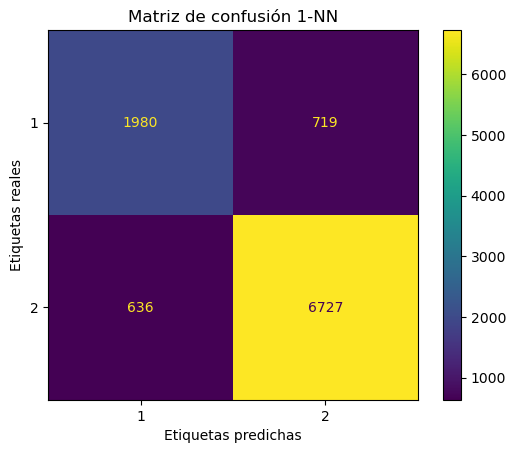

In [9]:
knn = KNeighborsClassifier(n_neighbors = 1)
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    knn.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = knn.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)


acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('1-NN')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión 1-NN")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/1-NN.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.

plt.show()



### **Clasificador 3-NN**


Accuracy: 0.8824
Balanced accuracy: 0.8328
Recall: 0.7258
Specificity: 0.9398
AUC: 0.7258
MCC: 0.6918
Precision: 0.8156
F1-score: 0.7681


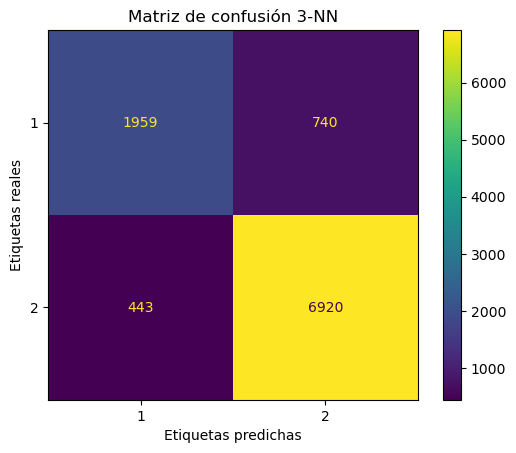

In [10]:
knn = KNeighborsClassifier(n_neighbors = 3)
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    knn.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = knn.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)


acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('3-NN')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión 3-NN")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/3-NN.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.

plt.show()

### **Clasificador 5-NN**



Accuracy: 0.8836
Balanced accuracy: 0.8297
Recall: 0.7132
Specificity: 0.9461
AUC: 0.7132
MCC: 0.6933
Precision: 0.8290
F1-score: 0.7668


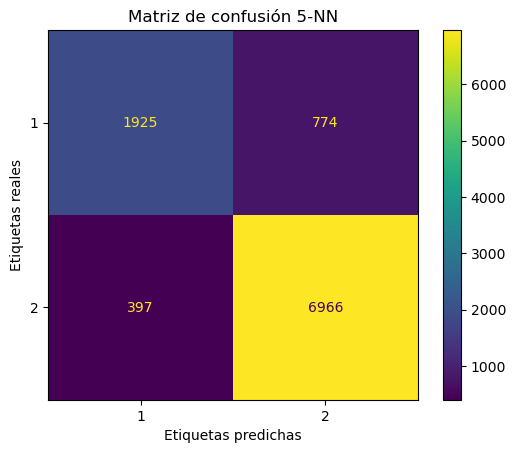

In [11]:
knn = KNeighborsClassifier(n_neighbors = 5)

y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    knn.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = knn.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('5-NN')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión 5-NN")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/5-NN.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.

plt.show()
plt.show()

### Clasificador 7-NN

Accuracy: 0.8839
Balanced accuracy: 0.8279
Recall: 0.7069
Specificity: 0.9488
AUC: 0.7069
MCC: 0.6934
Precision: 0.8350
F1-score: 0.7657


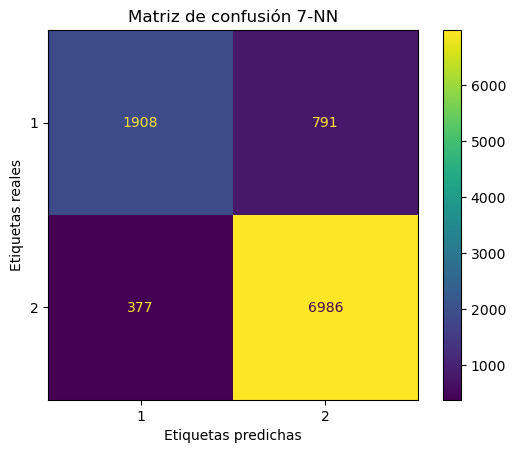

In [12]:
knn = KNeighborsClassifier(n_neighbors = 7)
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    knn.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = knn.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('7-NN')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión 7-NN")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/7-NN.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.

plt.show()
plt.show()

# Naïve Bayes

### **Naïve Bayes con kernel Gaussiano**

Accuracy: 0.8200
Balanced accuracy: 0.8169
Recall: 0.8103
Specificity: 0.8236
AUC: 0.8103
MCC: 0.5902
Precision: 0.6274
F1-score: 0.7072


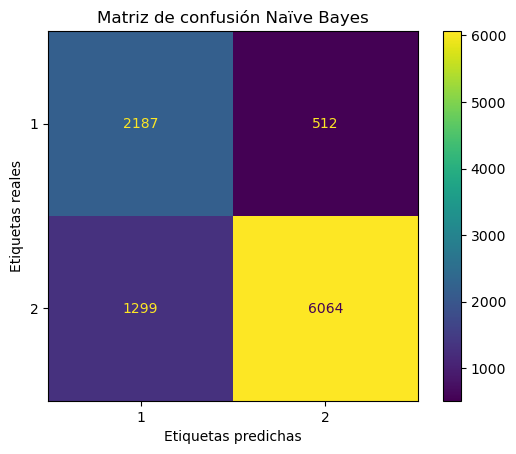

In [13]:
gnb = GaussianNB()
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]
    
    #Entrenar modelo
    gnb.fit(X_train, y_train)

    #Evaluar modelo
    y_eval= gnb.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('NaiveBayes')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión Naïve Bayes")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/NaiveBayes.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.
plt.show()

# Decision Tree

Accuracy: 0.9011
Balanced accuracy: 0.8735
Recall: 0.8140
Specificity: 0.9330
AUC: 0.8140
MCC: 0.7478
Precision: 0.8167
F1-score: 0.8154


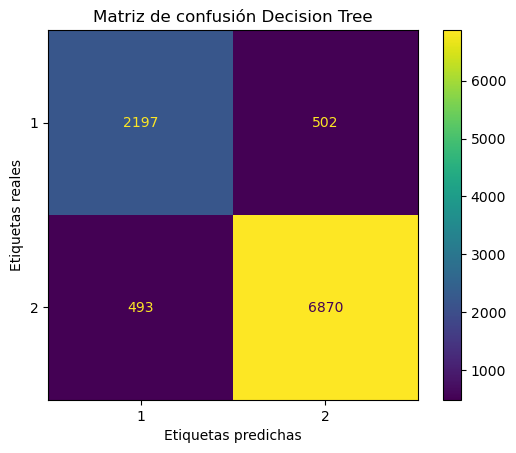

In [14]:
clf = DecisionTreeClassifier()
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]
    
    #Entrenar modelo
    clf.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = clf.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('DT')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión Decision Tree")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/DecisionTree.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.
plt.show()

# Random Forest

Accuracy: 0.9431
Balanced accuracy: 0.9144
Recall: 0.8525
Specificity: 0.9762
AUC: 0.8525
MCC: 0.8525
Precision: 0.9293
F1-score: 0.8893


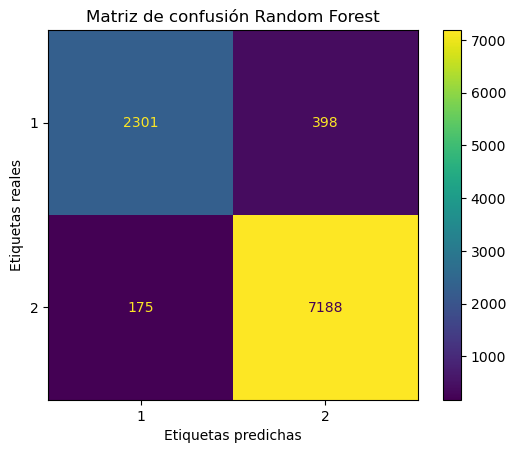

In [15]:
clf = RandomForestClassifier()
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    clf.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = clf.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('RF')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión Random Forest")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/RandomForest.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.
plt.show()

# Bagging

Accuracy: 0.9218
Balanced accuracy: 0.9014
Recall: 0.8574
Specificity: 0.9454
AUC: 0.8574
MCC: 0.8012
Precision: 0.8520
F1-score: 0.8547


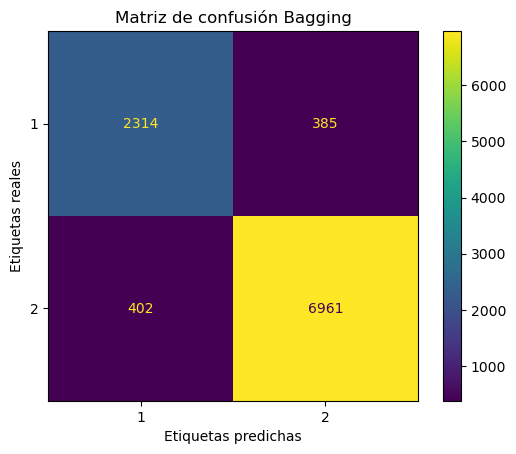

In [16]:
clf = BaggingClassifier()
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    clf.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = clf.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('Bagging')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión Bagging")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/Bagging.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.
plt.show()

# AdaBoost

Accuracy: 0.9357
Balanced accuracy: 0.9142
Recall: 0.8677
Specificity: 0.9606
AUC: 0.8677
MCC: 0.8350
Precision: 0.8898
F1-score: 0.8786


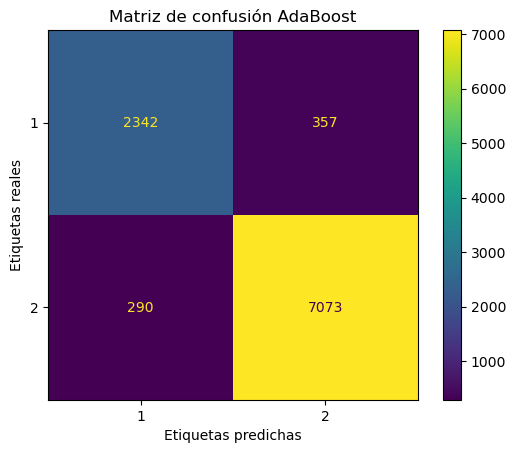

In [17]:
clf = AdaBoostClassifier()
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    clf.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = clf.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)


resultados['Classifier'].append('AdaBoost')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión AdaBoost")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/AdaBoost.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.
plt.show()

# Multi Layer Perceptron (MLP)

Accuracy: 0.7798
Balanced accuracy: 0.6020
Recall: 0.2186
Specificity: 0.9855
AUC: 0.2186
MCC: 0.3561
Precision: 0.8465
F1-score: 0.3475


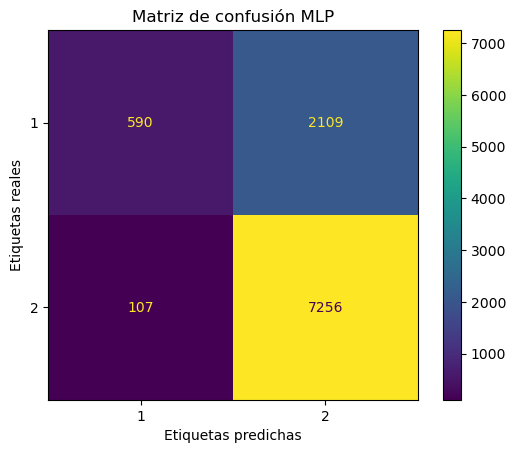

In [18]:
clf =  MLPClassifier(hidden_layer_sizes = (400,), activation = 'tanh', learning_rate = 'adaptive', solver = 'sgd', early_stopping = False, max_iter=500)
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    clf.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = clf.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('MLP')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión MLP")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/MLP.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.
plt.show()


# Support Vector Machine (SVM)

### **SVM con kernel RBF**

Accuracy: 0.8859
Balanced accuracy: 0.8340
Recall: 0.7221
Specificity: 0.9459
AUC: 0.7221
MCC: 0.6999
Precision: 0.8304
F1-score: 0.7725


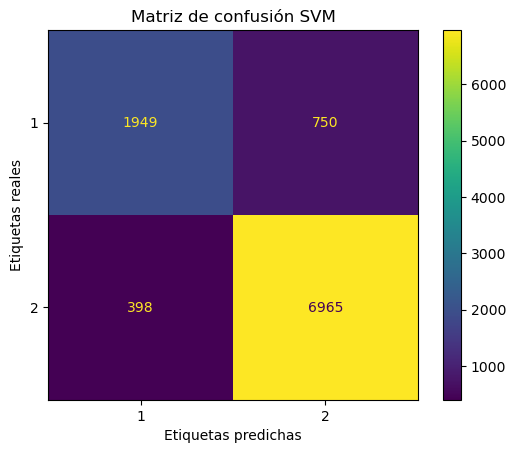

In [19]:
svc = SVC(kernel='rbf')
y_true, y_pred = list(), list()

for fold_no in range(1,n_folds+1):

    X_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/X_train_fold_' + str(fold_no) + '.csv', header=None)
    X_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/X_test_fold_' + str(fold_no) + '.csv', header=None)
    y_train = pd.read_csv(path_k_fold_cross_vaildation + 'train/y_train_fold_' + str(fold_no) + '.csv', header=None)[0]
    y_test = pd.read_csv(path_k_fold_cross_vaildation + 'test/y_test_fold_' + str(fold_no) + '.csv', header=None)[0]

    #Entrenar modelo
    svc.fit(X_train, y_train)

    #Evaluar modelo
    y_eval = svc.predict(X_test.values)

    #store
    y_true.extend(y_test)
    y_pred.extend(y_eval)

acc = accuracy_score(y_true, y_pred)
b_acc = balanced_accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred, pos_label=pos_class)
prec = precision_score(y_true, y_pred, pos_label=pos_class)
f1 = f1_score(y_true, y_pred, pos_label=pos_class)
mcc = matthews_corrcoef(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

resultados['Classifier'].append('SVM')
resultados['Accuracy'].append(acc)
resultados['Balanced_Accuracy'].append(b_acc)
resultados['Recall'].append(rec)
resultados['AUC'].append(auc)
resultados['MCC'].append(mcc)
resultados['Precision'].append(prec)
resultados['F1-score'].append(f1)

#Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[pos_class,neg_class])

(tp, fn, fp, tn) = cm.ravel()
spec = tn/(tn+fp)

resultados['Specificity'].append(spec)

print('Accuracy: %.4f' % acc)
print('Balanced accuracy: %.4f' % b_acc)
print('Recall: %.4f' % rec)
print('Specificity: %.4f' % spec)
print('AUC: %.4f' % rec)
print('MCC: %.4f' % mcc)
print('Precision: %.4f' % prec)
print('F1-score: %.4f' % f1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[pos_class,neg_class])
disp.plot()

plt.title("Matriz de confusión SVM")
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas reales')

# Guardar la gráfica en un archivo
plt.savefig('matrices_de_confusion/SVM.png')  # puedes cambiar la extensión a .pdf, .jpg, .svg, etc.
plt.show()


# Resultados

In [20]:
# Crear un DataFrame a partir del diccionario resultados
df_resultados = pd.DataFrame(resultados)

# Convertir el DataFrame a una tabla Markdown
markdown_table = df_resultados.to_markdown(index=False)

# Imprimir la tabla Markdown
print(markdown_table)


| Classifier   |   Accuracy |   Balanced_Accuracy |   Recall |   Specificity |      AUC |      MCC |   Precision |   F1-score |
|:-------------|-----------:|--------------------:|---------:|--------------:|---------:|---------:|------------:|-----------:|
| 1-NN         |   0.865335 |            0.823614 | 0.733605 |      0.913622 | 0.823614 | 0.65374  |    0.756881 |   0.745061 |
| 3-NN         |   0.882429 |            0.832829 | 0.725824 |      0.939834 | 0.832829 | 0.691798 |    0.81557  |   0.768085 |
| 5-NN         |   0.883622 |            0.829654 | 0.713227 |      0.946082 | 0.829654 | 0.693292 |    0.829027 |   0.76678  |
| 7-NN         |   0.88392  |            0.827863 | 0.706928 |      0.948798 | 0.827863 | 0.69343  |    0.835011 |   0.76565  |
| NaiveBayes   |   0.820016 |            0.816939 | 0.8103   |      0.823577 | 0.816939 | 0.590187 |    0.627367 |   0.707195 |
| DT           |   0.901113 |            0.873524 | 0.814005 |      0.933044 | 0.873524 | 0.747841 |    

# Test estadístico de Friedman

In [21]:
df = pd.DataFrame(resultados)

# Paso 1: Asignar rangos a los valores para cada métrica y clasificador
metricas = ['Accuracy', 'Balanced_Accuracy', 'Recall', 'AUC', 'MCC', 'Precision', 'F1-score']

for metrica in metricas:
    df[metrica + '_Rango'] = rankdata(df[metrica])

# Paso 2: Calcular el rango promedio para cada clasificador
df['Rango_Promedio'] = df[['Accuracy_Rango', 'Balanced_Accuracy_Rango', 'Recall_Rango', 'AUC_Rango', 'MCC_Rango', 'Precision_Rango', 'F1-score_Rango']].mean(axis=1)

# Reformulamos los datos para el test de Friedman
friedman_data = df[['Accuracy_Rango', 'Balanced_Accuracy_Rango', 'Recall_Rango', 'AUC_Rango', 'MCC_Rango', 'Precision_Rango', 'F1-score_Rango']].values
print(friedman_data)

# Calculamos la estadística de prueba de Friedman
estadistica_friedman, p_value = friedmanchisquare(*friedman_data)
print("")
print(f"Valor p: {p_value}")
print("")
# Interpretar el resultado
alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula. Hay diferencias significativas entre los clasificadores.")
else:
    print("No hay suficiente evidencia para rechazar la hipótesis nula. No hay diferencias significativas entre los clasificadores.")

[[ 3.  3.  6.  3.  3.  2.  3.]
 [ 4.  6.  5.  6.  4.  3.  6.]
 [ 5.  5.  3.  5.  5.  5.  5.]
 [ 6.  4.  2.  4.  6.  7.  4.]
 [ 2.  2.  7.  2.  2.  1.  2.]
 [ 8.  8.  8.  8.  8.  4.  8.]
 [11. 11.  9. 11. 11. 11. 11.]
 [ 9.  9. 10.  9.  9.  9.  9.]
 [10. 10. 11. 10. 10. 10. 10.]
 [ 1.  1.  1.  1.  1.  8.  1.]
 [ 7.  7.  4.  7.  7.  6.  7.]]

Valor p: 8.452200568168028e-09

Rechazamos la hipótesis nula. Hay diferencias significativas entre los clasificadores.
